# Analyse de la qualité des eaux Chinoises


## Objectif 

À rédiger précisément dans le rapport.

Étudier et modéliser la qualité des eaux chinoises afin d'expliquer et de prédire un indice de pollution à partir des caractéristiques géographiques et de la composition chimique des eaux étudiées.

In [2]:
#imports
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import seaborn as sns
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error

In [3]:
#séparer le data set en testset 10% et trainset 90%
csv_path = 'dataset.csv'
df = pd.read_csv(csv_path)
df = df.drop(columns=['Unnamed: 0'], errors='ignore')  # errors='ignore' évite l'erreur si la colonne n'existe pas
RANDOM_STATE = 42
# séparation aléatoire 90%/10%
train_df, val_df = train_test_split(df, test_size=0.10, random_state=RANDOM_STATE)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f'Total lignes: {len(df)} ; Train: {len(train_df)} ({len(train_df)/len(df):.2%}) ; Validation: {len(val_df)} ({len(val_df)/len(df):.2%})')

Total lignes: 3000 ; Train: 2700 (90.00%) ; Validation: 300 (10.00%)


## 3) Analyse descriptive des variables
Do a descriptive analysis of the variables of the model. Provide a table
 with mean, standard deviation, skewness and kurtosis. Show boxplots
 of the variables, and the correlation matrix.

Table des statistiques descriptives (variables numériques):


,mean,sd,skewness,kurtosis
Water_Temperature_C,20.0290,4.9190,0.0161,-0.0055
pH,7.2080,0.5974,0.2001,-0.1219
Dissolved_Oxygen_mg_L,7.9844,1.9768,0.0172,-0.1360
Conductivity_uS_cm,509.0740,104.2109,0.0195,0.1299
Turbidity_NTU,5.0504,5.0559,2.0644,7.2691
Nitrate_mg_L,2.0290,0.5294,0.1031,0.0127
Nitrite_mg_L,0.0204,0.0102,-0.0162,-0.0222
Ammonia_N_mg_L,0.5154,0.2071,0.0431,-0.1113
Total_Phosphorus_mg_L,0.1034,0.0518,-0.0365,-0.0897
Total_Nitrogen_mg_L,3.0898,0.5290,0.1530,0.0601


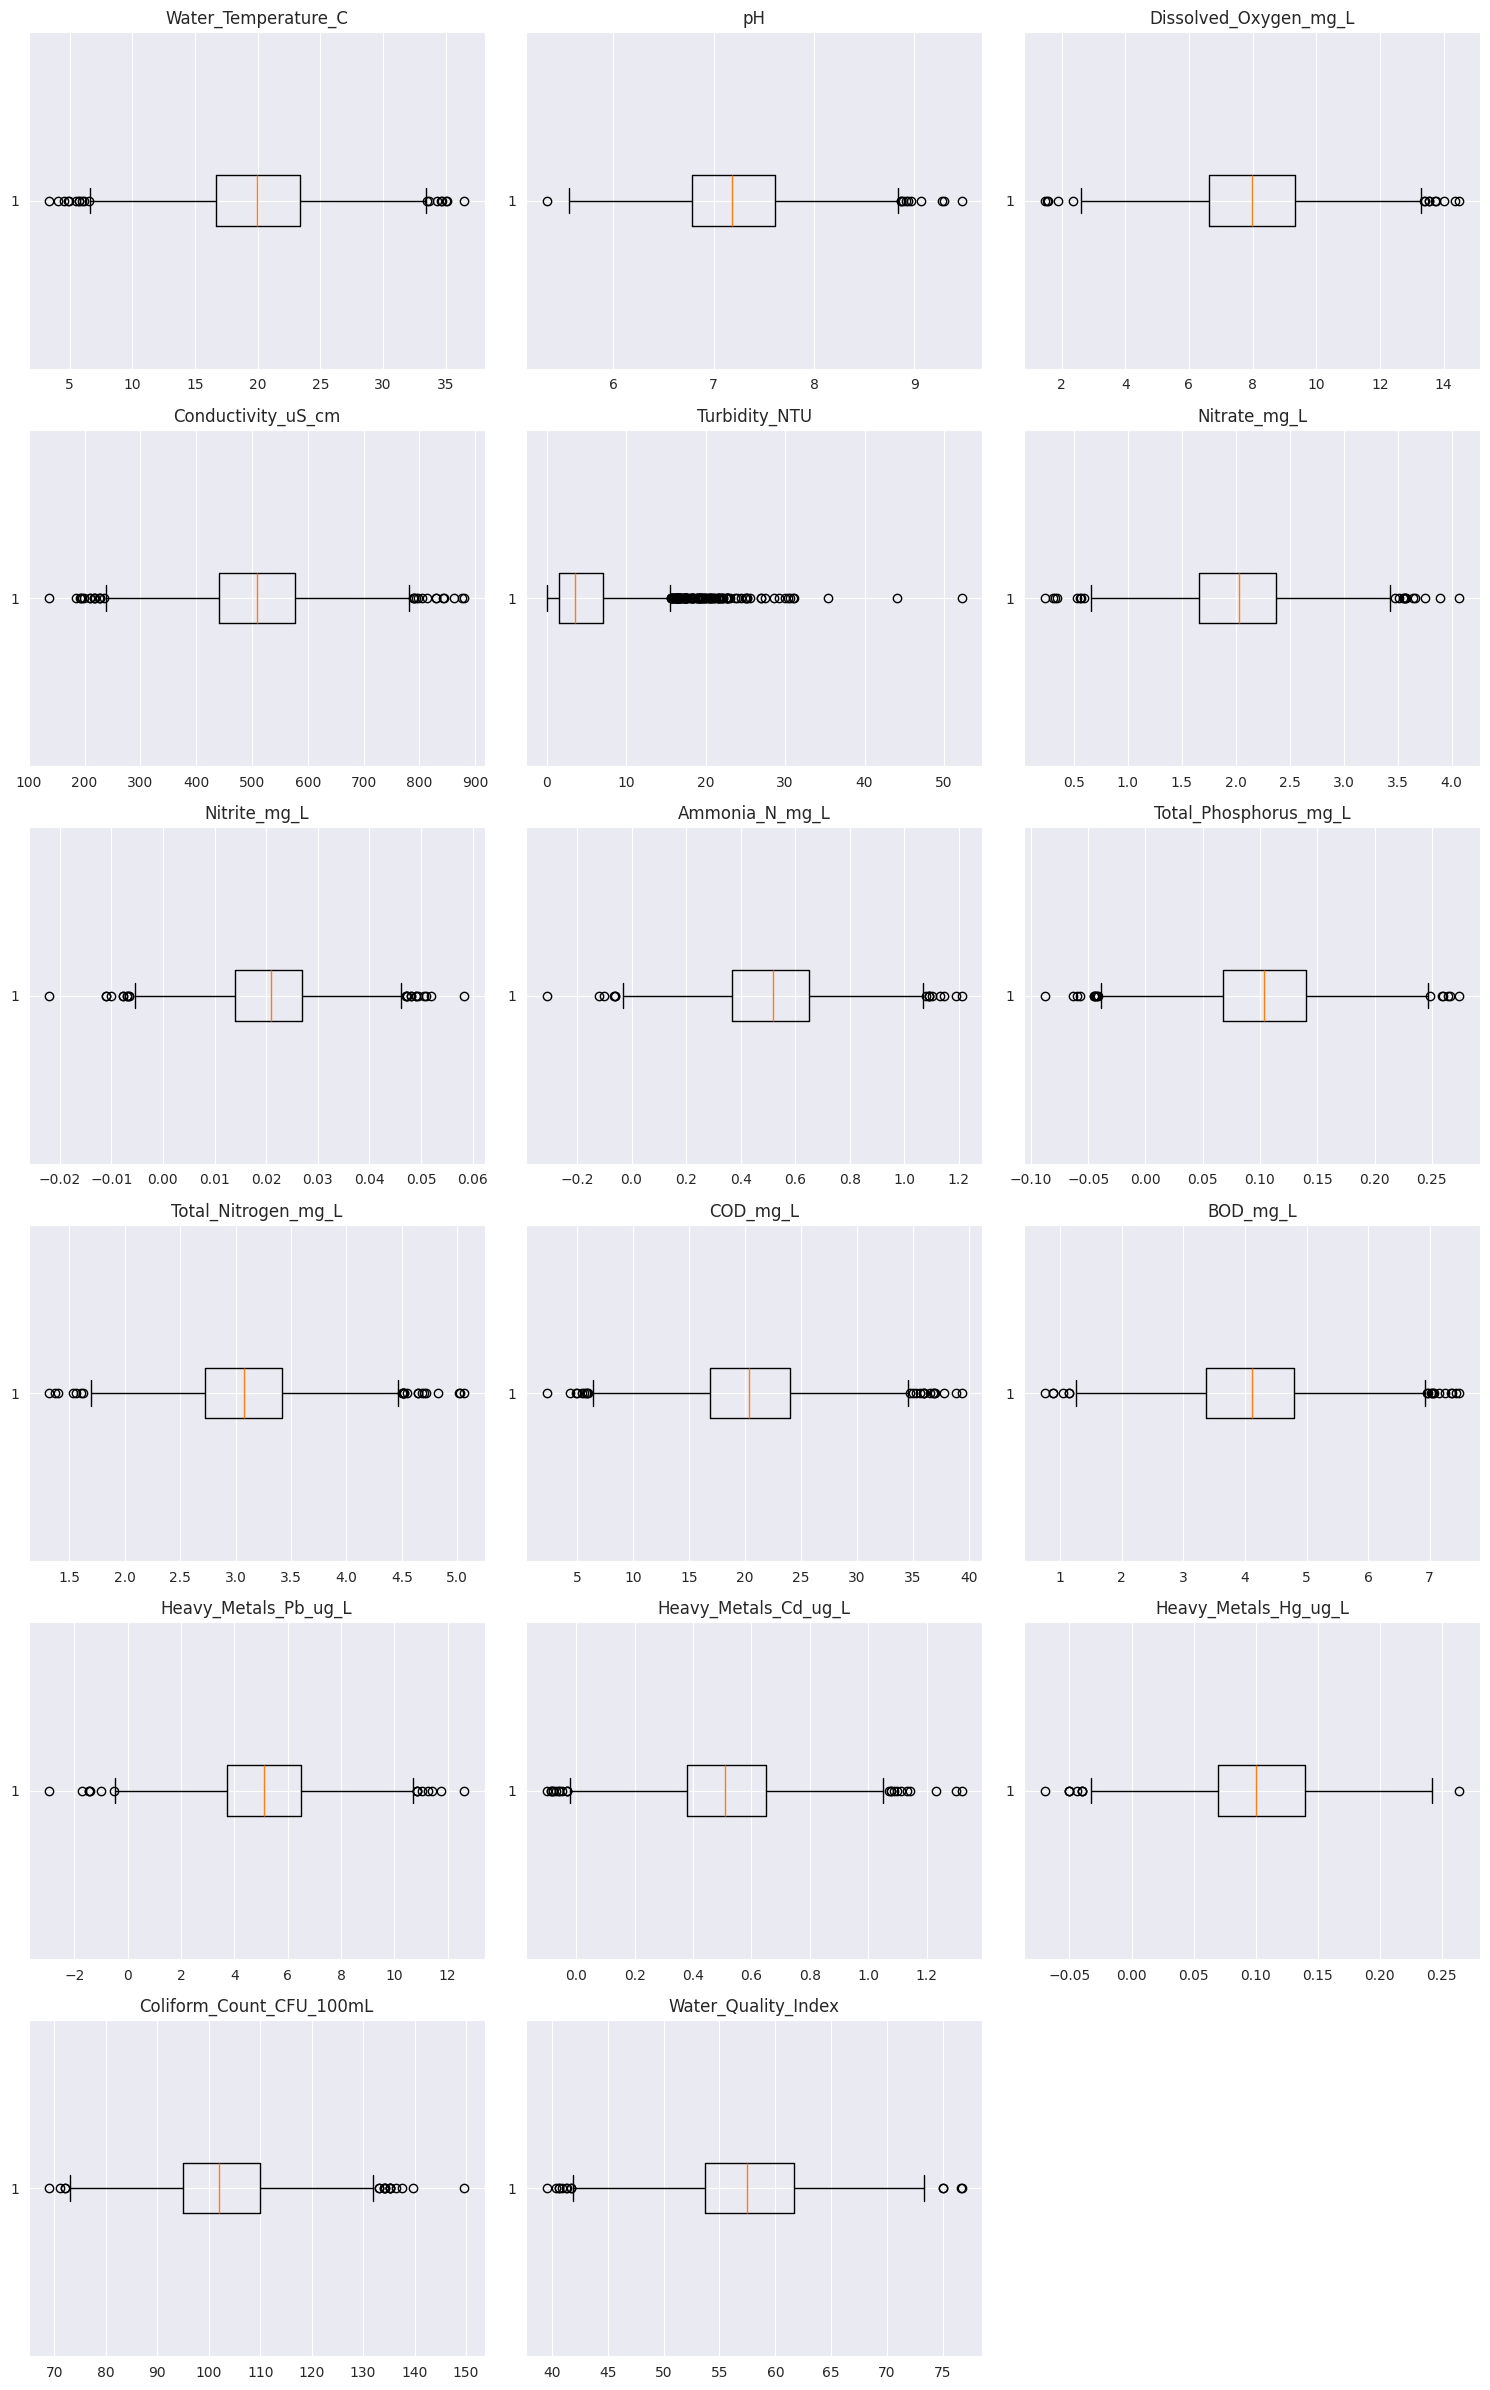

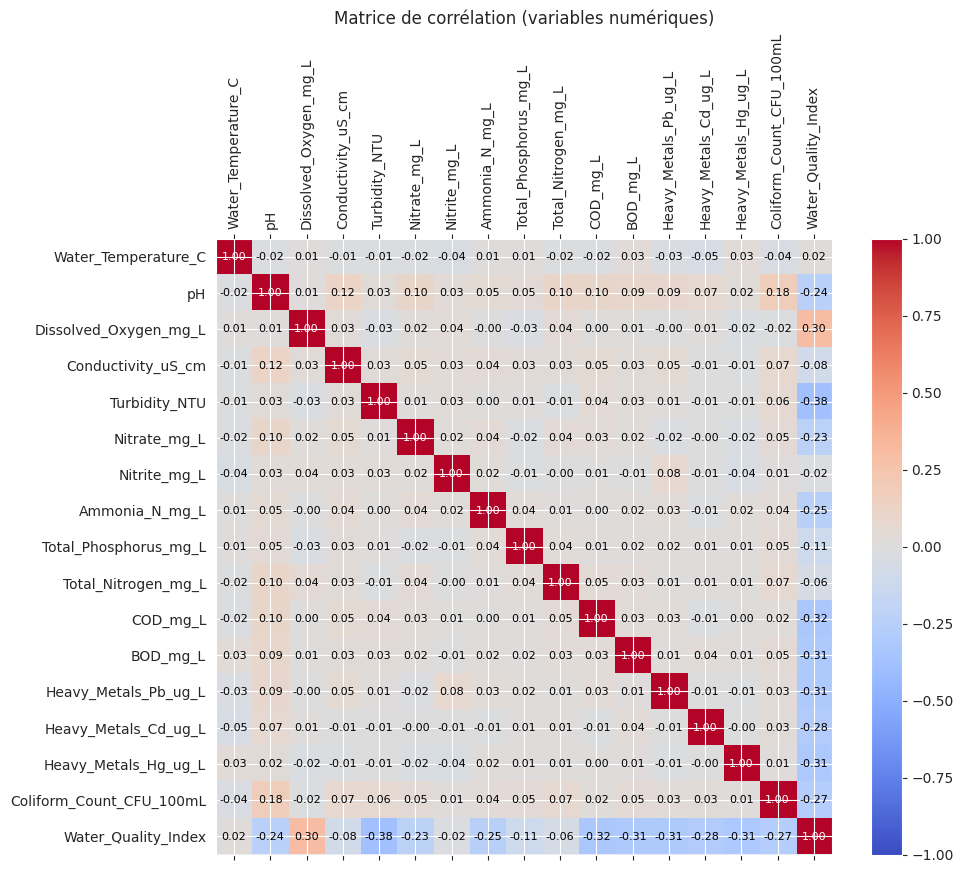

In [4]:
# calcule de la moyenne, ecart-type, skewness et kurtosis + boxplot et correlation matrix
response_var = '<Water_Quality_Index>'

num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

#table
stats_table = pd.DataFrame({
    'mean':train_df[num_cols].mean(),
    'sd': train_df[num_cols].std(),
    'skewness': train_df[num_cols].skew(),
    'kurtosis': train_df[num_cols].kurt()
}).round(4)
print('Table des statistiques descriptives (variables numériques):')
display(stats_table)

#boxplot
cols = num_cols
n = len(cols)
ncols = 3
nrows = (n + ncols - 1) // ncols
plt.figure(figsize=(5 * ncols, 4 * max(1, nrows)))
for i, c in enumerate(cols, 1):
    plt.subplot(nrows, ncols, i)
    plt.boxplot(train_df[c].dropna(), vert=False)
    plt.title(c)
plt.tight_layout()
plt.show()

#correlation matrix
corr = train_df[num_cols].corr()
fig, ax = plt.subplots(figsize=(10,8))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ax.set_xticks(range(len(num_cols)))
ax.set_yticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=90)
ax.set_yticklabels(num_cols)

for (i, j), val in np.ndenumerate(corr.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white' if abs(val)>0.5 else 'black', fontsize=8)
plt.title('Matrice de corrélation (variables numériques)')
plt.show()


## 4) Sélection de modèle et vérification des hypothèses 
Select an adequate model for the response variable by considering all
 quantitative and qualitative variables and by using our model selec
tion strategies. Consider also possible interactions of the qualitative
 variables with one or several quantitative variables. Verify the under
lying hypotheses and, if necessary, take remedial actions. For example,
 check for : 
  (a) nonlinearity
 (b) outliers and/or influential observations,
 (c) multicollinearity,
 (d) heteroskedasticty, and
 (e) autocorrelation.

# +

 ## 5) Test for significance of the estimated coefficients 
Test for significance of the estimated coefficients of the obtained model,
and interpret their signs. Give a more detailed interpretation of the
coefficients of the qualitative variables.

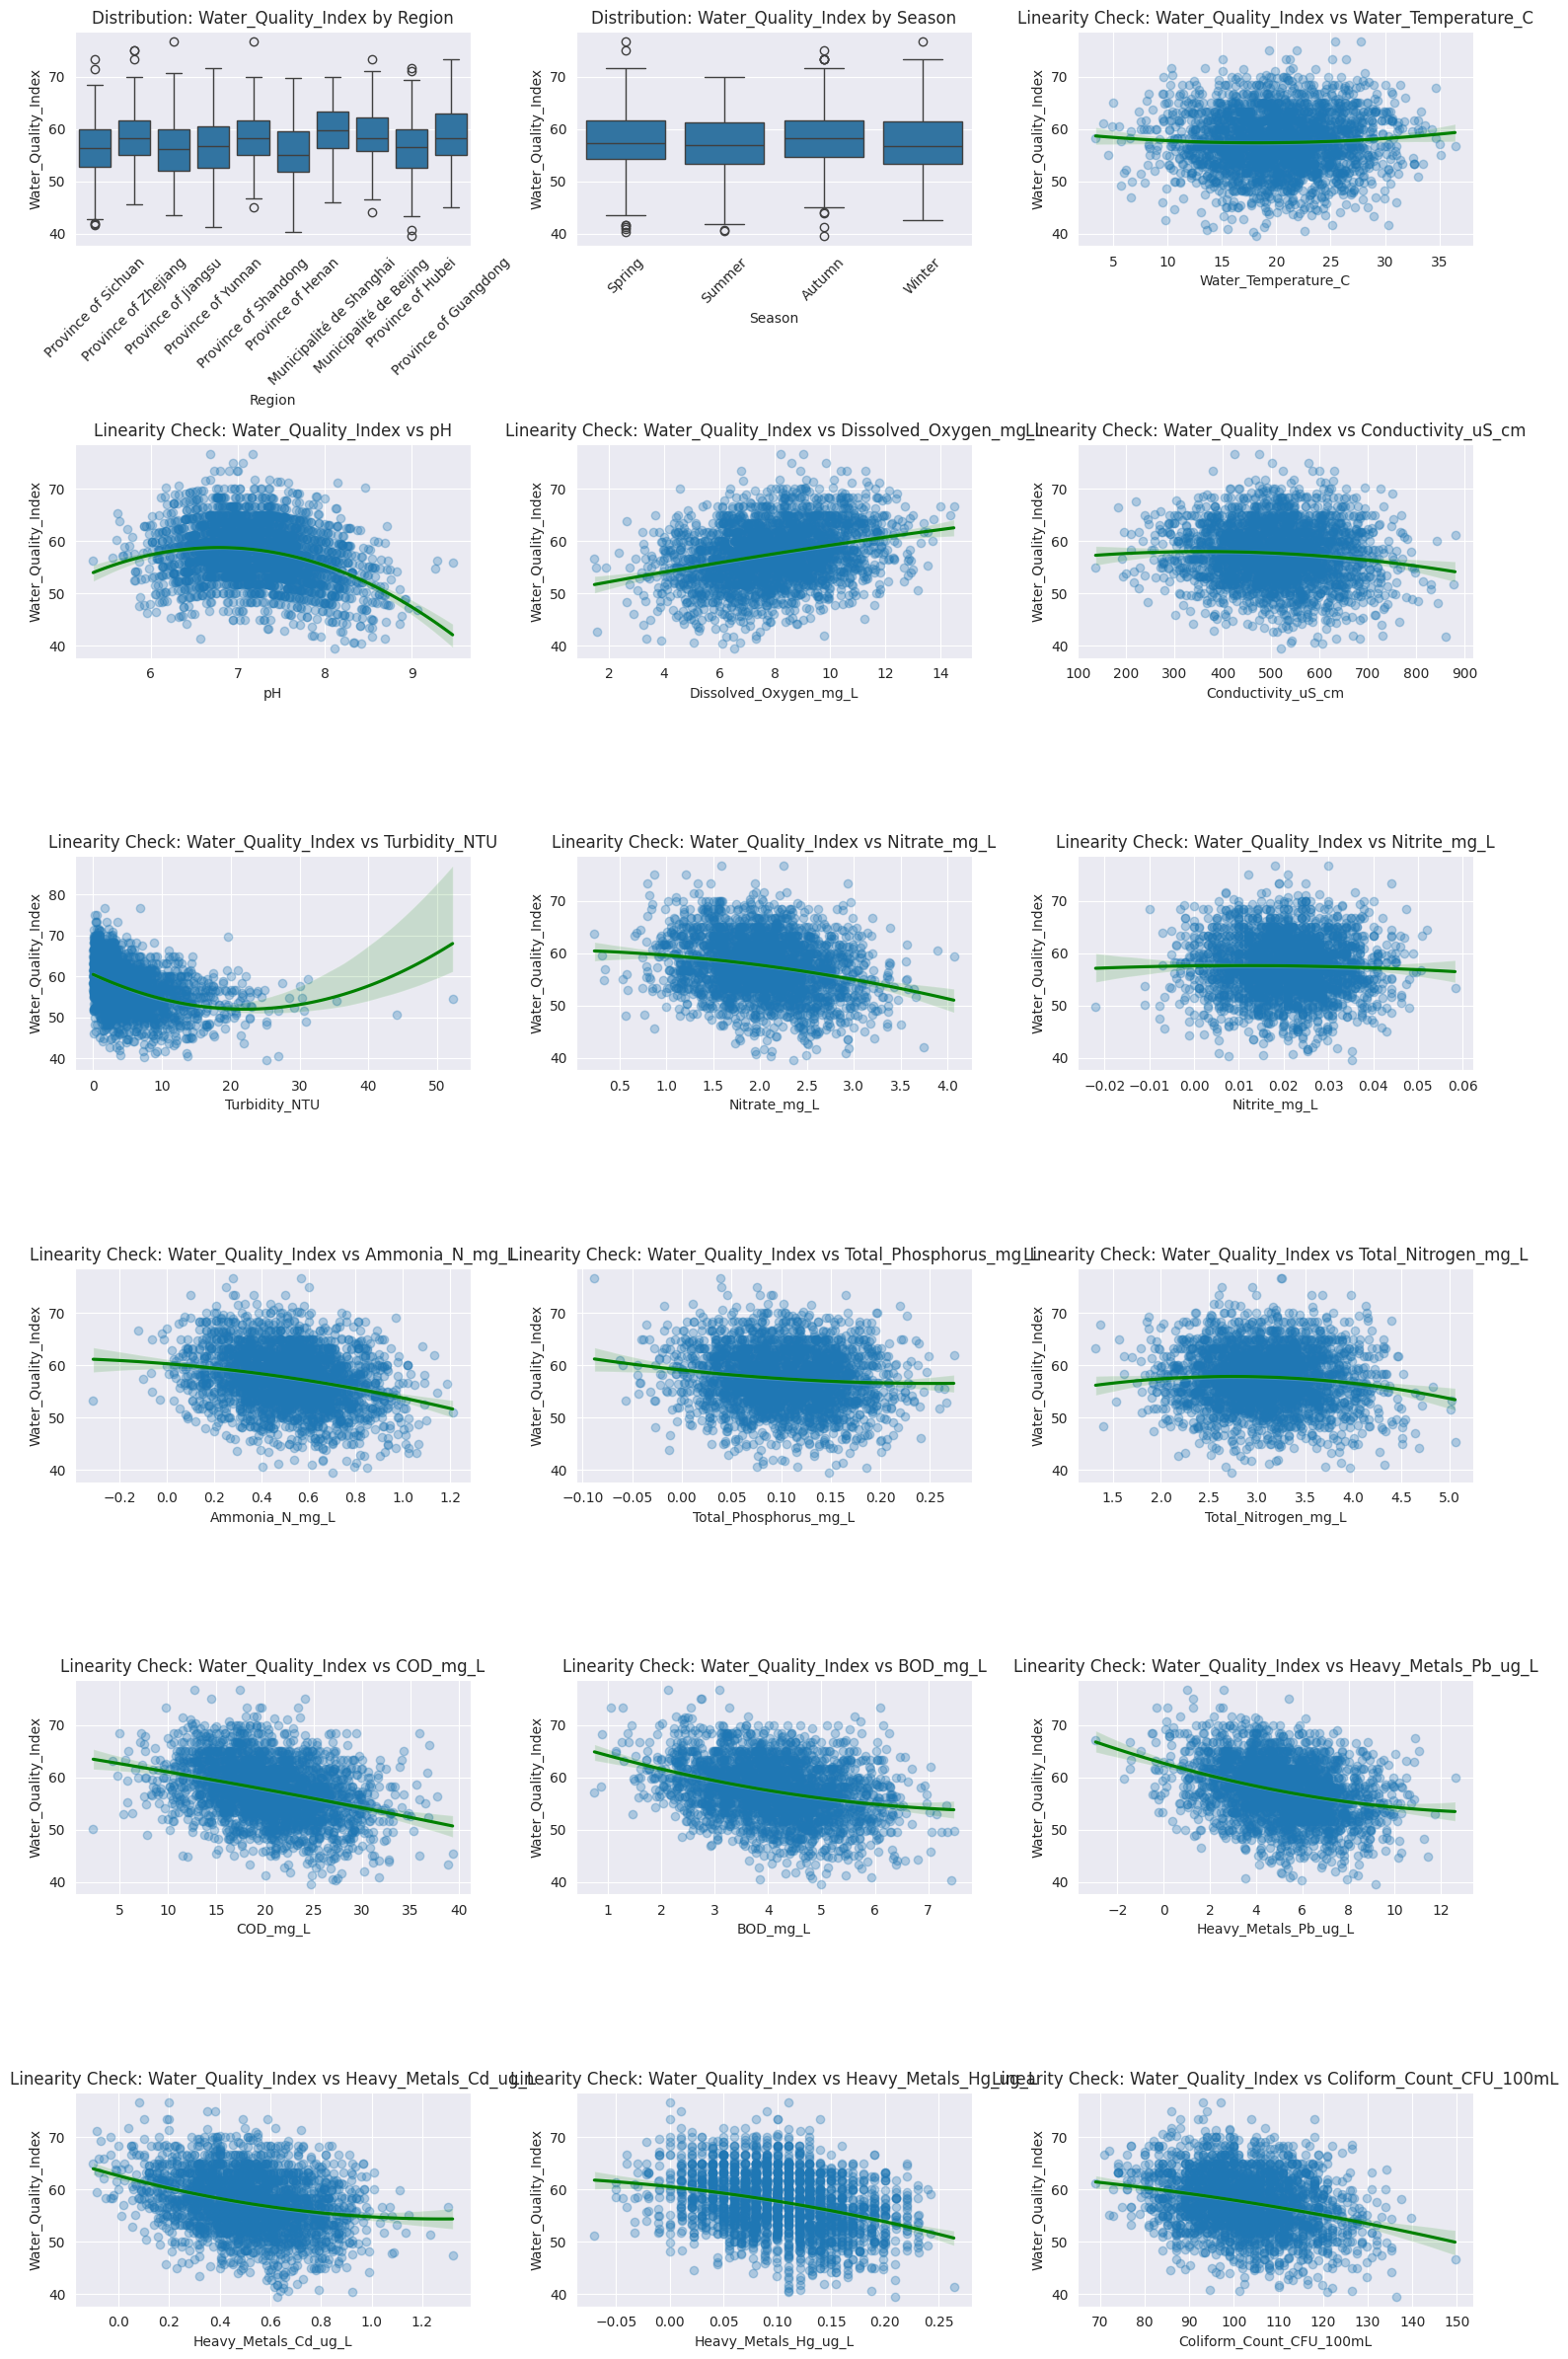

In [5]:

def pairwiseplot_for_linearity(df, y_var):
    #on récupère toutes les colonnes sauf la cible (y_var)
    x_vars = [col for col in df.columns if col != y_var and col != None]
    
    n = len(x_vars)
    ncols = 3  
    nrows = (n + ncols - 1) // ncols 
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
    axes = axes.flatten() if n > 1 else [axes]  
    
    for i, x_var in enumerate(x_vars):
        ax = axes[i]
        
        #x numérique
        if pd.api.types.is_numeric_dtype(df[x_var]):
            sns.regplot(data=df, x=x_var, y=y_var, 
                        order=2,  
                        scatter_kws={'alpha': 0.3}, 
                        line_kws={'color': 'green'},
                        ax=ax)
            ax.set_title(f"Linearity Check: {y_var} vs {x_var}")
            
        #x catégoriel
        else:
            sns.boxplot(data=df, x=x_var, y=y_var, ax=ax)
            ax.set_title(f"Distribution: {y_var} by {x_var}")
            ax.tick_params(axis='x', rotation=45)
        
        ax.set_xlabel(x_var)
        ax.set_ylabel(y_var)
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

pairwiseplot_for_linearity(train_df, "Water_Quality_Index")

In [6]:
#on utilise get_dummies pour transformer "Winter", "Spring" en 0 et 1.
train_df_encoded = pd.get_dummies(train_df, columns=['Region', 'Season'], drop_first=True, dtype=int)

X_train = train_df.copy()

X_train['pH_squared'] = X_train['pH'] ** 2
X_train['Turbidity_squared'] = X_train['Turbidity_NTU'] ** 2
X_train = pd.get_dummies(X_train, columns=['Region', 'Season'], drop_first=True, dtype=int)

y_train = X_train['Water_Quality_Index']
X_train = X_train.drop(columns=['Water_Quality_Index'])

X_train = sm.add_constant(X_train)

#estimation du modèle complet
model_full = sm.OLS(y_train, X_train).fit()

print(model_full.summary())

                             OLS Regression Results                            
Dep. Variable:     Water_Quality_Index   R-squared:                       0.868
Model:                             OLS   Adj. R-squared:                  0.866
Method:                  Least Squares   F-statistic:                     583.4
Date:                 Tue, 23 Dec 2025   Prob (F-statistic):               0.00
Time:                         11:37:11   Log-Likelihood:                -5721.5
No. Observations:                 2700   AIC:                         1.151e+04
Df Residuals:                     2669   BIC:                         1.169e+04
Df Model:                           30                                         
Covariance Type:             nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------


In [7]:
#VIF -> check de la multicolinéarité + centrer pH et Turbidity
mean_pH = train_df['pH'].mean()
mean_Turb = train_df['Turbidity_NTU'].mean()

X_train['pH_centered'] = train_df['pH'] - mean_pH
X_train['pH_sq_centered'] = X_train['pH_centered'] ** 2

X_train['Turb_centered'] = train_df['Turbidity_NTU'] - mean_Turb
X_train['Turb_sq_centered'] = X_train['Turb_centered'] ** 2

#on évite les doublons pour pas casser le model
vars_to_drop = ['pH', 'pH_squared', 'Turbidity_NTU', 'Turbidity_squared', 'const']

#redondance
vars_to_drop += ['Total_Nitrogen_mg_L', 'Total_Phosphorus_mg_L'] 
X_clean = X_train.drop(columns=vars_to_drop, errors='ignore')

vif_data = pd.DataFrame()
vif_data["Variable"] = X_clean.columns
vif_data["VIF"] = [variance_inflation_factor(X_clean.values, i) for i in range(len(X_clean.columns))]
vif_data = vif_data.sort_values('VIF', ascending=False)

print(vif_data)

                           Variable        VIF
11         Coliform_Count_CFU_100mL  57.094229
2                Conductivity_uS_cm  23.813033
0               Water_Temperature_C  16.349953
1             Dissolved_Oxygen_mg_L  16.222751
7                          BOD_mg_L  15.828531
6                          COD_mg_L  15.575703
3                      Nitrate_mg_L  15.227430
9              Heavy_Metals_Cd_ug_L   7.270474
5                    Ammonia_N_mg_L   7.197828
8              Heavy_Metals_Pb_ug_L   7.072769
4                      Nitrite_mg_L   5.044030
10             Heavy_Metals_Hg_ug_L   4.924283
18       Region_Province of Sichuan   2.151706
22                    Season_Summer   2.087513
15         Region_Province of Hubei   2.075360
27                 Turb_sq_centered   2.075220
19        Region_Province of Yunnan   2.063213
14         Region_Province of Henan   2.051218
21                    Season_Spring   2.046477
16       Region_Province of Jiangsu   2.017538
23           

In [8]:
#on enlève les VIF > 10 (surtout les très hauts) combinés d'une p-val > 0.05 ou alors trop proches d'autres variables
vars_to_drop = ['Water_Temperature_C', 'Conductivity_uS_cm', 
              'Coliform_Count_CFU_100mL']

X_final_vif = X_clean.drop(columns=vars_to_drop, errors='ignore')

vif_data = pd.DataFrame()
vif_data["Variable"] = X_final_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_final_vif .values, i) for i in range(len(X_final_vif.columns))]
vif_data = vif_data.sort_values('VIF', ascending=False)

print(vif_data)

                           Variable        VIF
0             Dissolved_Oxygen_mg_L  14.617053
5                          BOD_mg_L  14.375673
4                          COD_mg_L  14.259640
1                      Nitrate_mg_L  13.811463
7              Heavy_Metals_Cd_ug_L   7.022377
3                    Ammonia_N_mg_L   6.945417
6              Heavy_Metals_Pb_ug_L   6.834324
2                      Nitrite_mg_L   4.959491
8              Heavy_Metals_Hg_ug_L   4.773239
24                 Turb_sq_centered   2.074482
15       Region_Province of Sichuan   2.072940
19                    Season_Summer   2.058021
18                    Season_Spring   2.020617
12         Region_Province of Hubei   1.999841
11         Region_Province of Henan   1.972753
20                    Season_Winter   1.971921
16        Region_Province of Yunnan   1.969048
13       Region_Province of Jiangsu   1.931966
17      Region_Province of Zhejiang   1.917594
10     Region_Province of Guangdong   1.907388
9   Region_Mu

In [9]:
X_curr = sm.add_constant(X_final_vif) 
model_step1 = sm.OLS(y_train, X_curr).fit()

print(model_step1.summary())

                             OLS Regression Results                            
Dep. Variable:     Water_Quality_Index   R-squared:                       0.839
Model:                             OLS   Adj. R-squared:                  0.837
Method:                  Least Squares   F-statistic:                     557.2
Date:                 Tue, 23 Dec 2025   Prob (F-statistic):               0.00
Time:                         11:37:12   Log-Likelihood:                -5986.7
No. Observations:                 2700   AIC:                         1.203e+04
Df Residuals:                     2674   BIC:                         1.218e+04
Df Model:                           25                                         
Covariance Type:             nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------


In [10]:
#on nettoie selon la p-val, mtn que le model est beaucoup plus significatif
vars_to_drop_final = [
    'Nitrite_mg_L',                     # P = 0.525
    'Region_Municipalité de Shanghai',  # P = 0.821
    'Region_Province of Shandong',      # P = 0.819  
    'Region_Province of Zhejiang'       # P = 0.379                
]
X_final_clean = X_curr.drop(columns=vars_to_drop_final, errors='ignore')

X_final_clean = sm.add_constant(X_final_clean)
model_final_clean = sm.OLS(y_train, X_final_clean).fit()

print(model_final_clean.summary())

                             OLS Regression Results                            
Dep. Variable:     Water_Quality_Index   R-squared:                       0.839
Model:                             OLS   Adj. R-squared:                  0.838
Method:                  Least Squares   F-statistic:                     664.0
Date:                 Tue, 23 Dec 2025   Prob (F-statistic):               0.00
Time:                         11:37:12   Log-Likelihood:                -5987.3
No. Observations:                 2700   AIC:                         1.202e+04
Df Residuals:                     2678   BIC:                         1.215e+04
Df Model:                           21                                         
Covariance Type:             nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const 

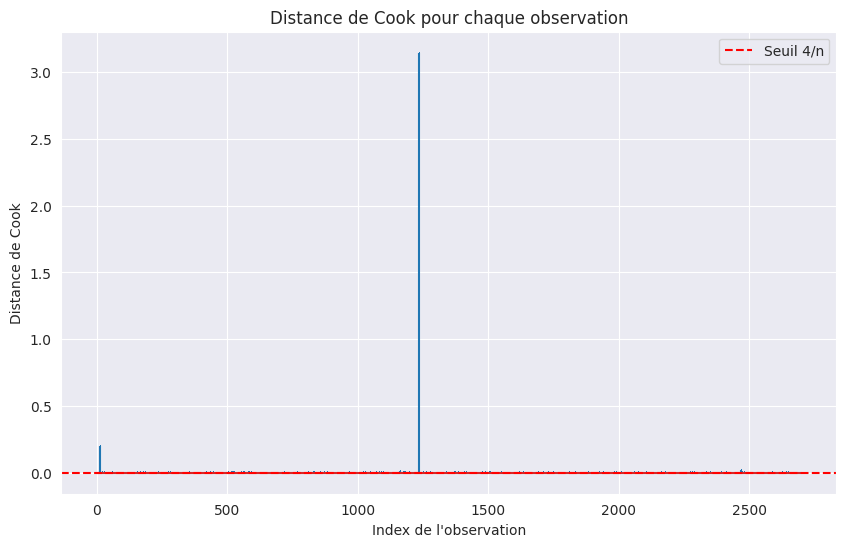

In [11]:
#cook distances
influence = model_final_clean.get_influence()
cooks_d = influence.cooks_distance[0]
n = len(X_final_clean)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(y=4/n, color='r', linestyle='--', label='Seuil 4/n')
plt.title("Distance de Cook pour chaque observation")
plt.xlabel("Index de l'observation")
plt.ylabel("Distance de Cook")
plt.legend()
plt.show()

In [12]:
idx_coupable = np.argmax(cooks_d)
print(f"L'observation problématique est à l'index : {idx_coupable}")

indices_a_supprimer = [1237, 15]
#suppression des points hyper-influents
X_final_sans_outlier = X_final_clean.drop(index=indices_a_supprimer, errors='ignore')
y_train_sans_outlier = y_train.drop(index=indices_a_supprimer, errors='ignore')
model_final_final = sm.OLS(y_train_sans_outlier, X_final_sans_outlier).fit()

print(f"R-squared avant : {model_final_clean.rsquared:.4f}")
print(f"R-squared après : {model_final_final.rsquared:.4f}")
print(model_final_final.summary())

L'observation problématique est à l'index : 1237
R-squared avant : 0.8389
R-squared après : 0.8505
                             OLS Regression Results                            
Dep. Variable:     Water_Quality_Index   R-squared:                       0.851
Model:                             OLS   Adj. R-squared:                  0.849
Method:                  Least Squares   F-statistic:                     725.1
Date:                 Tue, 23 Dec 2025   Prob (F-statistic):               0.00
Time:                         11:37:12   Log-Likelihood:                -5881.8
No. Observations:                 2698   AIC:                         1.181e+04
Df Residuals:                     2676   BIC:                         1.194e+04
Df Model:                           21                                         
Covariance Type:             nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
----

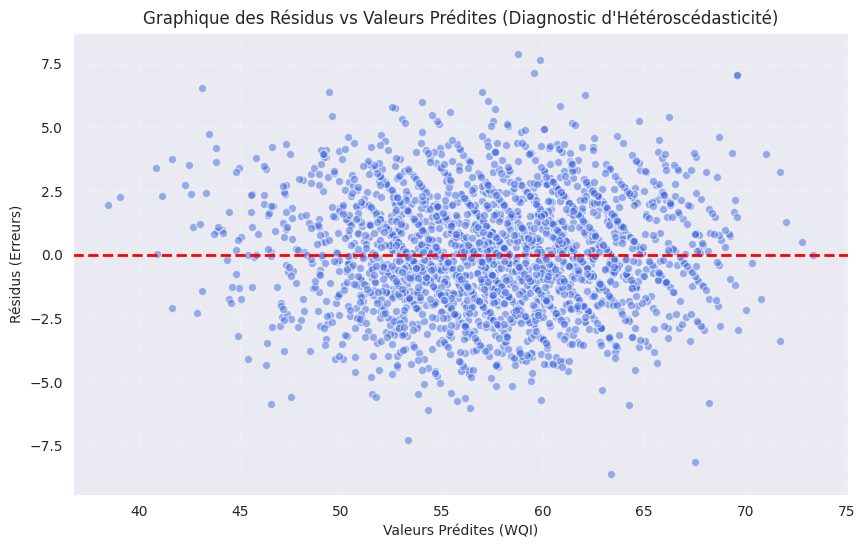

In [13]:
import matplotlib.pyplot as plt

#calcul des résidus et des valeurs prédites
residuals = model_final_final.resid
fitted_values = model_final_final.fittedvalues

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5, color='royalblue', edgecolors='white')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title("Graphique des Résidus vs Valeurs Prédites (Diagnostic d'Hétéroscédasticité)")
plt.xlabel("Valeurs Prédites (WQI)")
plt.ylabel("Résidus (Erreurs)")
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

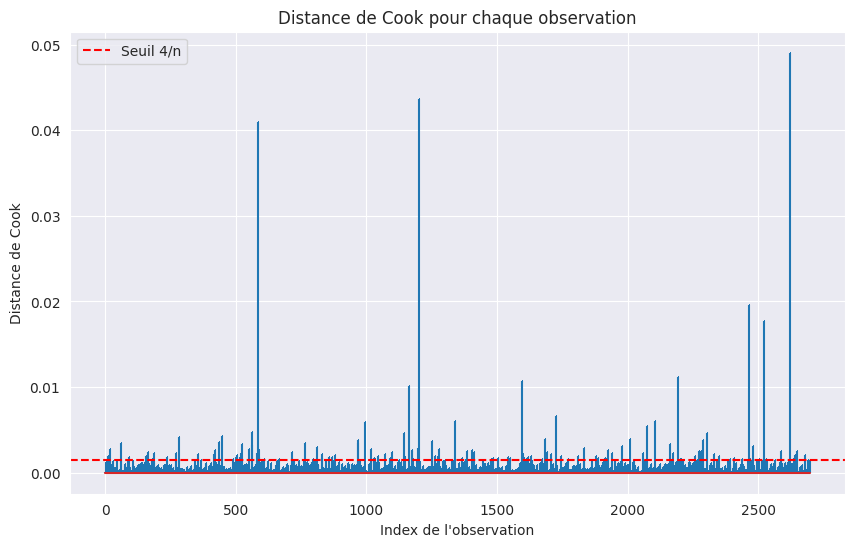

In [14]:
influence = model_final_final.get_influence()
cooks_d = influence.cooks_distance[0]
n = len(X_final_sans_outlier)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(y=4/n, color='r', linestyle='--', label='Seuil 4/n')
plt.title("Distance de Cook pour chaque observation")
plt.xlabel("Index de l'observation")
plt.ylabel("Distance de Cook")
plt.legend()
plt.show()

In [15]:
X_val_final = X_final_sans_outlier.drop(columns=vars_to_drop_final, errors='ignore')
X_val_final = sm.add_constant(X_val_final)

y_pred_final = model_final_final.predict(X_val_final)

#mspe
mspe_final = mean_squared_error(y_train_sans_outlier, y_pred_final)

print(f"MSPE du modèle final (nettoyé) : {mspe_final:.4f}")

MSPE du modèle final (nettoyé) : 4.5826


## 6) Test d'une combinaison linéaire à 2 coefficients


In [16]:
#H0 : L'impact du Plomb est égal à celui du Cadmium
test_q6 = model_final_final.t_test("Heavy_Metals_Pb_ug_L = Heavy_Metals_Cd_ug_L")
print(test_q6)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             6.7157      0.206     32.679      0.000       6.313       7.119


## 7) Test d'un sous-ensemble de coefficients égaux à zéro


In [17]:
vars_season = []
for variable_name in model_final_final.params.index:
    if "Season" in variable_name:
        vars_season.append(variable_name)

liste_hypotheses = []
for variable in vars_season:
    equation = f"{variable} = 0"
    liste_hypotheses.append(equation)

hypothesis = ", ".join(liste_hypotheses)
f_test = model_final_final.f_test(hypothesis)

print(f"Statistique F : {f_test.fvalue:.4f}")
print(f"P-value : {f_test.pvalue:.4f}")
if f_test.pvalue < 0.05:
    print("Conclusion : On rejette H0. La saison a un impact significatif sur la qualité de l'eau.")
else:
    print("Conclusion : On ne rejette pas H0. Une fois les autres variables prises en compte, la saison n'apporte pas d'info significative.")

Statistique F : 1.8635
P-value : 0.1336
Conclusion : On ne rejette pas H0. Une fois les autres variables prises en compte, la saison n'apporte pas d'info significative.


## 8) Intervalles de prédiction pour les données de validation
Calculate prediction intervals for the validation data. Does the cover
age percentage of these intervals correspond to the nominal level? If
 not, what could be a reason?

In [18]:
# 1. Feature Engineering sur le set de VALIDATION (identique au train)
X_val = val_df.copy()

# Création des termes carrés et dummies
X_val['pH_squared'] = X_val['pH'] ** 2
X_val['Turbidity_squared'] = X_val['Turbidity_NTU'] ** 2
X_val = pd.get_dummies(X_val, columns=['Region', 'Season'], drop_first=True, dtype=int)

# 2. Centrage (IMPORTANT : utiliser mean_pH et mean_Turb calculés sur le TRAIN en cellule 9)
X_val['pH_centered'] = X_val['pH'] - mean_pH
X_val['pH_sq_centered'] = X_val['pH_centered'] ** 2
X_val['Turb_centered'] = X_val['Turbidity_NTU'] - mean_Turb
X_val['Turb_sq_centered'] = X_val['Turb_centered'] ** 2

# 3. Alignement des colonnes
# On ne garde que les colonnes présentes dans le modèle final (hors constante qu'on ajoute après)
cols_model = model_final_final.params.index.drop('const')

# Si une colonne du modèle manque dans la validation (ex: une région absente du test set), on l'ajoute remplie de 0
for col in cols_model:
    if col not in X_val.columns:
        X_val[col] = 0

X_val = X_val[cols_model] # On ordonne comme le train
X_val = sm.add_constant(X_val) # On ajoute la constante

# 4. Prédictions et Intervalles
predictions = model_final_final.get_prediction(X_val)
pred_frame = predictions.summary_frame(alpha=0.05) # alpha 0.05 pour 95% confiance

# 5. Calcul de la couverture
y_true = val_df['Water_Quality_Index']
is_covered = (y_true >= pred_frame['obs_ci_lower']) & (y_true <= pred_frame['obs_ci_upper'])
coverage = is_covered.mean() * 100

print(f"Couverture des intervalles de prédiction (95% nominal) : {coverage:.2f}%")

# RMSE pour info
rmse_val = np.sqrt(mean_squared_error(y_true, pred_frame['mean']))
print(f"RMSE sur Validation : {rmse_val:.4f}")

Couverture des intervalles de prédiction (95% nominal) : 94.00%
RMSE sur Validation : 2.1938


### Conclusion du point 8

## 9) Conclusion


## 10) Déclaration d'utilisation d'IA


tkt